Accuracy: 1.0
Confusion Matrix:
[[16  0]
 [ 0 24]]
AUC: 1.0


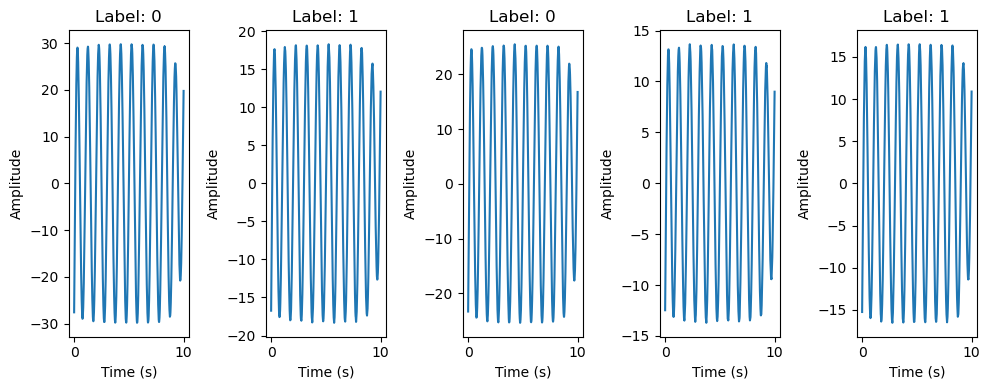

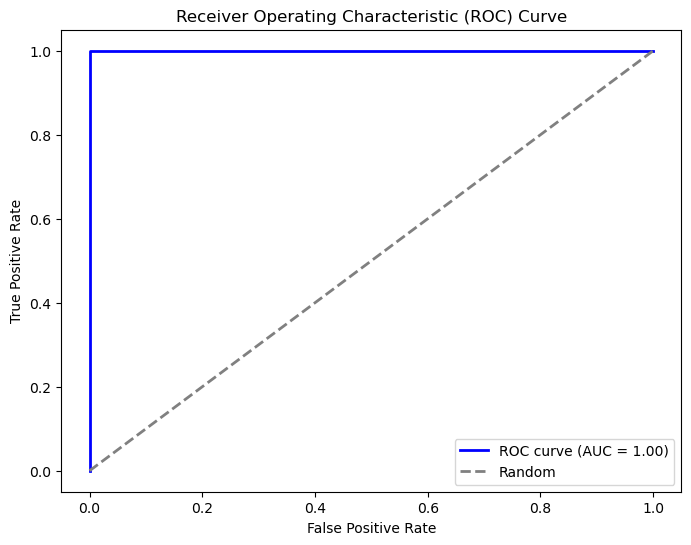

Labels: [0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0
 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1
 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0
 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1
 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0]


In [1]:
 # import necessary python libraries 
    """"
    From this code one can learn how to generate the sinusoidal eeg signals synthetically, How to add noise to it,
    how to apply filter to denoise it, how to label the disease and healthy, split the data into train and test,
    and apply svm for binary clasification.
    What is missing here?
    ----> segmentaion, time, frequency, and time-frequecny domain analysis
    ------> Epoch,FFT, weblet transform and AR analysis will be added soon
    """
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
%matplotlib inline

def generate_eeg_signal(duration, sampling_rate, frequencies, amplitudes):
    t = np.arange(0, duration, 1/sampling_rate)
    num_channels = len(frequencies)
    signals = [amplitude * np.sin(2 * np.pi * frequency * t) for frequency, amplitude in zip(frequencies, amplitudes)]
    eeg_signal = np.vstack(signals)
    return t, eeg_signal

def generate_synthetic_eeg_data(num_samples, duration, sampling_rate, frequencies, amplitudes, noise_level=0.1, condition='healthy'):
    synthetic_data = []
    labels = []

    for _ in range(num_samples):
        # Generate EEG signal
        if condition == 'healthy':
            amplitude_variation = np.random.uniform(0.8, 1.2, len(frequencies))  # Simulate variation in healthy signals
        elif condition == 'disease':
            amplitude_variation = np.random.uniform(0.5, 0.8, len(frequencies))  # Simulate reduced amplitude in disease signals

        t, eeg_signal = generate_eeg_signal(duration, sampling_rate, frequencies, amplitudes * amplitude_variation)

        # Add Gaussian noise
        noisy_signal = eeg_signal + noise_level * np.random.normal(size=eeg_signal.shape)

        # Store synthetic EEG data
        synthetic_data.append(noisy_signal)

        # Assign label (0 for healthy, 1 for disease)
        label = 0 if condition == 'healthy' else 1
        labels.append(label)

    return np.array(synthetic_data), np.array(labels)

# Parameters for synthetic data generation
num_samples_per_condition = 100
duration = 10  # seconds
sampling_rate = 100  # Hz
frequencies = np.linspace(1, 30, 19)  # Example frequencies for 19 channels (adjust as needed)
amplitudes = 50  # Example amplitude
noise_level = 0.1

# Generate synthetic EEG data for healthy condition
healthy_data, healthy_labels = generate_synthetic_eeg_data(
    num_samples_per_condition, duration, sampling_rate, frequencies, amplitudes, noise_level, condition='healthy'
)

# Generate synthetic EEG data for disease condition
disease_data, disease_labels = generate_synthetic_eeg_data(
    num_samples_per_condition, duration, sampling_rate, frequencies, amplitudes, noise_level, condition='disease'
)

# Apply bandpass filter to the synthetic data
#lowcut = 1  # Lower cutoff frequency
#highcut = 30  # Upper cutoff frequency

#healthy_filtered_data = np.array([bandpass_filter(channel, lowcut, highcut, sampling_rate) for channel in healthy_data])
#disease_filtered_data = np.array([bandpass_filter(channel, lowcut, highcut, sampling_rate) for channel in disease_data])

#Function to apply a bandpass filter
def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, padtype='constant', padlen=3*(max(len(b),len(a))-1))
    return filtered_data
# Apply bandpass filter to the synthetic data
lowcut = 1  # Lower cutoff frequency
highcut = 30  # Upper cutoff frequency
healthy_filtered_data = bandpass_filter(healthy_data, lowcut, highcut, sampling_rate)
disease_filtered_data = bandpass_filter(disease_data, lowcut, highcut, sampling_rate)




# Combine the datasets and labels
synthetic_data = np.concatenate([healthy_filtered_data, disease_filtered_data], axis=0)
labels = np.concatenate([healthy_labels, disease_labels])

# Shuffle the data and labels
shuffle_indices = np.random.permutation(len(synthetic_data))
synthetic_data = synthetic_data[shuffle_indices]
labels = labels[shuffle_indices]

# Apply train-test split
test_size = 0.2  # 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(synthetic_data, labels, test_size=test_size, random_state=42)

# reshape
X_train_flatten = X_train.reshape((X_train.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))

# Train an SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)  # You can choose a different kernel if needed (e.g., 'rbf')
svm_classifier.fit(X_train_flatten, y_train)

# Predict labels for the test set
y_pred = svm_classifier.predict(X_test_flatten)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate ROC curve and AUC
y_scores = svm_classifier.decision_function(X_test_flatten)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)



# Print results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("AUC:", roc_auc)


# Visualize a few samples
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(np.arange(0, duration, 1/sampling_rate), synthetic_data[i][0])  # Plot the first channel for simplicity
    plt.title(f'Label: {labels[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print labels
print("Labels:", labels)
